<a href="https://colab.research.google.com/github/veljkolazic17/OpenNetworks/blob/main/PRS1_novo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRS Domaći zadatak

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from queue import PriorityQueue

# Analiza

Na osnovu opisa zadatka prve svega moramo odredti matricu prelaza ovog sistema.

\begin{equation}
    P =
    \begin{bmatrix}
    0.2 & 0.15 & 0.1 & 0.05 \\
    0.3 &  0.2 &   0 &    0 \\
    0.3 &    0 & 0.2 &    0 \\
    0.3 &    0 &   0 &  0.2
    \end{bmatrix}
\end{equation}

Sada je potrebno izračunati protoke kroz svaki server koristeći sledeću jednačinu.
\begin{equation}
    \lambda = (I - P^T)^-1 \cdot \alpha
\end{equation}

In [112]:
K = [2,3,4,5]

In [113]:
def calculate_lambda(P : np.array) -> np.array:
  # Calculate P transposed
  PT = P.transpose()
  # Calculate Inverse matrix
  I = np.identity(P.shape[0])
  # Calculate A
  A = np.zeros(P.shape[0])
  A[0] = 1

  # Calculate lambda vector
  L = np.matmul(np.linalg.inv(np.subtract(I, PT)), A)
  return L

Pošto jačina ulaznog toka nije poznata, već se mora izračunati, ono što dobijamo primenom ove jednačine je zapravo odnos protoka kroz server i ulaznog jačine ulaznog toka.

Pošto je broj korisničkih diskova promenljiva vrednost $K = [2, 3, 4, 5]$, dobijamo sledeće rezultate za svako $K$ iz ovog skupa.

Kako bi mogli da pronadjemo parametar $\alpha_{max}$ moramo da odredimo iskorišćenja svih servera i odredimo server koji je usko grlo sistema, pa će samim tim protok biti ograničen protokom kroz isti taj server.

Korišćenjem Džeksonove teoreme možemo da izračunamo vrednosti proporcionalne iskorišćenju kroz svaki server korišćenjem prethodno izračunatog odnosa protoka i dolaznog intenziteta.

In [114]:
# Define S vector without K disks
S = np.array([0.00625, 0.01, 0.015, 0.015])

# Write to file L/A
P = np.array([[0.2, 0.15, 0.1, 0.05],
                [0.3,  0.2,   0,    0],
                [0.3,    0, 0.2,    0],
                [0.3,    0,   0,  0.2]])

f = open('protoci_analiticki', 'w+')

a_max_arr = []
r_arr = [0.25, 0.50, 0.77, 0.99]
LRes_arr = []

for k in K:
  # Extend P matrix with probabilities of user disks
  P_prim = P
  S_prim = S

  P_prim = np.append(P, np.full([P.shape[0], k], 0.5/k) , axis = 1)
  P_prim = np.r_[P_prim, np.zeros([k, k + P_prim.shape[0]])]
  # Write to a file
  LRes = calculate_lambda(P_prim)
  LRes_arr.append(LRes)

  S_prim = np.append(S, np.full([k], 0.025))

  U_prim = np.multiply(LRes, S_prim)

  index = np.argmax(U_prim)
  if(index == 0):
    print("K = %d : Critical resource is processor" % k)
  elif index < 4:
    print("K = %d : Critical resource is system disk %d" % (k, index))
  else:
    print("K = %d : Critical resource is user disk %d" % (k, index - 3))



  a_max = (1/S_prim[index])/LRes[index]
  a_max_arr.append(a_max)

  lambda_ = 'K = ' + str(k) + '-'*64 + '\n' + np.array2string(LRes) + '\n'
  print(lambda_)
  f.write(lambda_)

f.close()

K = 2 : Critical resource is user disk 1
K = 2----------------------------------------------------------------
[1.45454545 0.27272727 0.18181818 0.09090909 0.5        0.5       ]

K = 3 : Critical resource is processor
K = 3----------------------------------------------------------------
[1.45454545 0.27272727 0.18181818 0.09090909 0.33333333 0.33333333
 0.33333333]

K = 4 : Critical resource is processor
K = 4----------------------------------------------------------------
[1.45454545 0.27272727 0.18181818 0.09090909 0.25       0.25
 0.25       0.25      ]

K = 5 : Critical resource is processor
K = 5----------------------------------------------------------------
[1.45454545 0.27272727 0.18181818 0.09090909 0.2        0.2
 0.2        0.2        0.2       ]



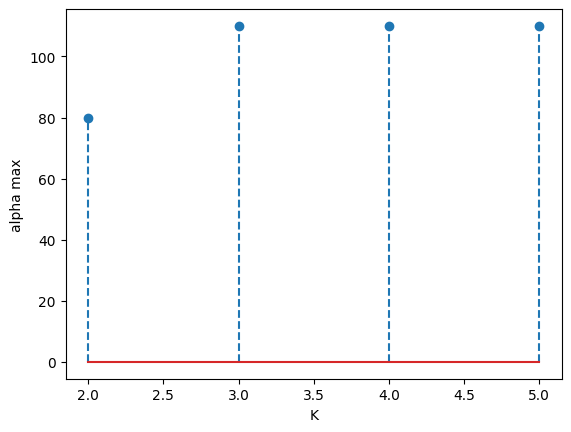

In [115]:
plt.stem(K, a_max_arr, linefmt='--')
plt.xlabel("K")
plt.ylabel("alpha max")

plt.show()

Nakong dobijenih rezultata možemo odrediti  $\alpha_{max}$ za svako $K$.

In [116]:
print('Alpha max for each K' + str(a_max_arr))

Alpha max for each K[80.00000000000001, 110.0, 110.0, 110.0]


Pošto smo dobili vrednosti za $\alpha_{max}$ sada možemo lako izračunati ostale tražene parametre korišćenjem osobina MM1 servera.

In [117]:
f = open('rezultati_analiticki', 'w+')

result_analyitical = {}

for ida, a in enumerate(a_max_arr):
  for r in r_arr:
    LRes = np.array(LRes_arr[ida])

    V = LRes

    LRes = LRes * a * r

    S_prim = S
    S_prim = np.append(S, np.full([ida + 2], 0.025))

    U_prim = np.multiply(LRes, S_prim)
    U_prim_inv = np.ones([LRes.size]) - U_prim

    J = np.divide(U_prim, U_prim_inv)
    R = np.divide(J, LRes)

    R_system = np.sum(V * R)

    key = 'k' + str(ida + 2) + 'a' + str(round(a*r))
    result_analyitical[key] = [LRes, U_prim, J, R, R_system]

    file_line = 'K = ' + str(ida+2) + '; lambda = ' + str(a*r) + 'L = \t' + str(LRes) + '\nU = \t' + str(U_prim) + '\nJ = \t' + str(J) + '\nR = \t' + str(R) + '\nR_system = \t' + str(R_system) + '\n' + '-'*64 + '\n'
    f.write(file_line)

f.close()

Rezultate možemo videti u prilogu "Rezultati analitički"

In [118]:
import threading
import random
import time

# Simualcija iterativno

Ovde možemo videti strukturu klase koja opisuje ponasanje jednog servera.

Klasa sadrži par polja koja opisuju stanje servera, a to su:
*   **name** - ime samog servera, mora biti unikatno
*   **visited** - ukupan broj poseta u jednom ciklusu simulacije
*   **speed** - brzina samog server u milisekundama
*   **queue** - broj poslova u redu za čekanje
*   **work_left** - ostatak vremena za obradu jednog posla
*   **next_server** - lista servera sa koji su sledeći u lancu obrade
*   **next_probability** - lista verovatnoća da se pređe u neki od servera iz niza next_server



Klasa sadrži i par metoda koja omogućavaju menjanje stanja:
*   **call** - metoda koju zove tajmer svake milisekunde. Ova metoda proverava da li ima poslova u redu za čekanje koji bi server mogao da obradi ili ako server trenutno radi da li je završio svoj rad i odredjuje kome sledećem treba da pošalje obradjeni posao.
*   **add_to_queue** - metoda koju pozivaju prethodni serveri ili tajmer i koja proseledjuje posao serveru nad kojim je metoda pozvana.


In [119]:
class Server ():

    name : str
    visited : int
    queue : int
    speed : float
    work_left : float
    next_server = []
    next_probability = []

    def __init__(self, servers, name, speed, next_server = [], next_probability = []):
      self.name = name
      self.speed = speed
      self.next_server = next_server
      self.next_probability = next_probability
      self.servers = servers
      self.servers[name] = self
      self.queue = 0
      self.visited = 0

    def goNext(self):
      if len(self.next_server) != 0:
        next = random.choices(self.next_server, self.next_probability, k=1)
        return self.servers[next[0]]
      return None

    def reset(self):
      self.visited = 0

U nastavku možemo videtu funkciju niti za pokretanje N simulacija sa parametrima $K$ i $α$. Konfiguraciju simulacije i sistema možemo videti na linijama 14-17. Nakon toga se pokreće ciklus simulacije i pozivanje **tick**-a tajmera za svaki server i ubacivanje poslova na CPU. Nakon isteka simulacije izračunavamo sve potrebne vrednosti i stavljamu ih u mapu koju kasnije koristimo za dalje izračunavanje.

In [120]:
results = {}


def thread_job(k, alpha, time, cycles):

  servers = {}

  user_disks = []
  user_disk_probabilities = [0.5/k] * k
  for i in range(k):
    user_disk = Server(servers, 'UserDisk' + str(i+1), 25)
    user_disks.append(user_disk.name)

  Server(servers, 'SystemDisk1', 10, user_disks + ['SystemDisk1', 'CPU'], user_disk_probabilities + [0.2, 0.3])
  Server(servers, 'SystemDisk2', 15, user_disks + ['SystemDisk2', 'CPU'], user_disk_probabilities + [0.2, 0.3])
  Server(servers, 'SystemDisk3', 15, user_disks + ['SystemDisk3', 'CPU'], user_disk_probabilities + [0.2, 0.3])
  Server(servers, 'CPU', 6.25, user_disks + ['SystemDisk1', 'SystemDisk2', 'SystemDisk3', 'CPU'], user_disk_probabilities + [0.15, 0.1, 0.05, 0.2])

  CPU_SPEED = servers['CPU'].speed
  number_of_jobs = 0

  for i in range(cycles):

      q = PriorityQueue()

      initial_lambda = (np.random.poisson(lam=alpha, size=None), 'alpha')
      q.put(initial_lambda)

      while time > 0:
          event_time, event_name = q.get()

          next_server = None

          # for i in range(len(q.queue)):
          #     t = list(q.queue[i])
          #     t[0] -= event_time
          #     q.queue[i] = tuple(t)

          if event_name == 'alpha':
              number_of_jobs += 1
              next_lambda = (np.random.poisson(lam=alpha, size=None), 'alpha')
              q.put(next_lambda)
              next_server = (np.random.poisson(lam=CPU_SPEED, size=None), 'CPU')
          else:
              server = servers[event_name]
              server.visited += 1
              server = server.goNext()
              if server != None:
                next_server = (np.random.poisson(lam=server.speed, size=None), server.name)

          if next_server != None:
            q.put(next_server)
          time -= event_time


  V_ = [servers['CPU'].visited/number_of_jobs,
      servers['SystemDisk1'].visited/number_of_jobs,
      servers['SystemDisk2'].visited/number_of_jobs,
      servers['SystemDisk3'].visited/number_of_jobs]
  for server in user_disks:
    V_.append(servers[server].visited/number_of_jobs)

  V = np.array(V_)
  L = V * alpha

  S_prim = S
  S_prim = np.append(S, np.full([k], 0.025))

  U = np.multiply(L, S_prim)
  U_inv = np.ones([L.size]) - U

  J = np.divide(U, U_inv)
  R = np.divide(J, L)

  R_system = np.sum(V * R)

  key = 'k' + str(k) + 'a' + str(round(alpha))


  results[key].append([L, U, J, R, R_system])

  print('Finished K = ' + str(k) + '; alpha = ' + str(alpha))


Sada pokrećemo određeni broj niti (za svaki pari $K$ i $r$) i izvršavamo cikluse a zatim čekamo da se sve niti završe. Nakon toga se rezultati usrednjavaju i upisuju u izlazni fajl.

In [121]:
time = 1800000
cycles = 1

threads = []

result_simulation = {}

for ida, a in enumerate(a_max_arr):
  for r in r_arr:
    key = 'k' + str(ida + 2) + 'a' + str(round(a * r))
    results[key] = []
    thread = threading.Thread(target=thread_job, args=(ida+2, a * r, time, cycles, ))
    thread.start()
    threads.append(thread)

for thread in threads:
  thread.join()

f = open('rezultati_simulacija','w+')

for key in results:
  res_arr = results[key]
  L = np.zeros(res_arr[0][0].size)
  U = np.zeros(res_arr[0][1].size)
  J = np.zeros(res_arr[0][2].size)
  R = np.zeros(res_arr[0][3].size)
  R_system = 0
  for iteration in res_arr:
    #Calculate L
    L += iteration[0]

    #Calculate U
    U += iteration[1]

    #Calculate J
    J += iteration[2]

    #Calculate R
    R += iteration[3]

    #Calculate R_system
    R_system += iteration[4]

  L /= cycles
  U /= cycles
  J /= cycles
  R /= cycles
  R_system /= cycles

  result_simulation[key] = [L, U, J, R, R_system]

  file_line = key + 'L = \t' + str(L) + '\nU = \t' + str(U) + '\nJ = \t' + str(J) + '\nR = \t' + str(R) + '\nR_system = \t' + str(R_system) + '\n' + '-'*64 + '\n'
  f.write(file_line)

f.close()

Finished K = 3; alpha = 108.9
Finished K = 3; alpha = 84.7
Finished K = 4; alpha = 108.9
Finished K = 5; alpha = 108.9
Finished K = 2; alpha = 79.20000000000002
Finished K = 4; alpha = 84.7
Finished K = 3; alpha = 55.0
Finished K = 5; alpha = 84.7
Finished K = 2; alpha = 61.600000000000016
Finished K = 5; alpha = 55.0
Finished K = 4; alpha = 55.0
Finished K = 3; alpha = 27.5
Finished K = 2; alpha = 40.00000000000001
Finished K = 2; alpha = 20.000000000000004
Finished K = 5; alpha = 27.5
Finished K = 4; alpha = 27.5


Nakon završetka simulacije možemo videti da se rezultati bliže očekivanim vrednostima analitičkog rešenja.

In [122]:
from tabulate import tabulate

# Grafici

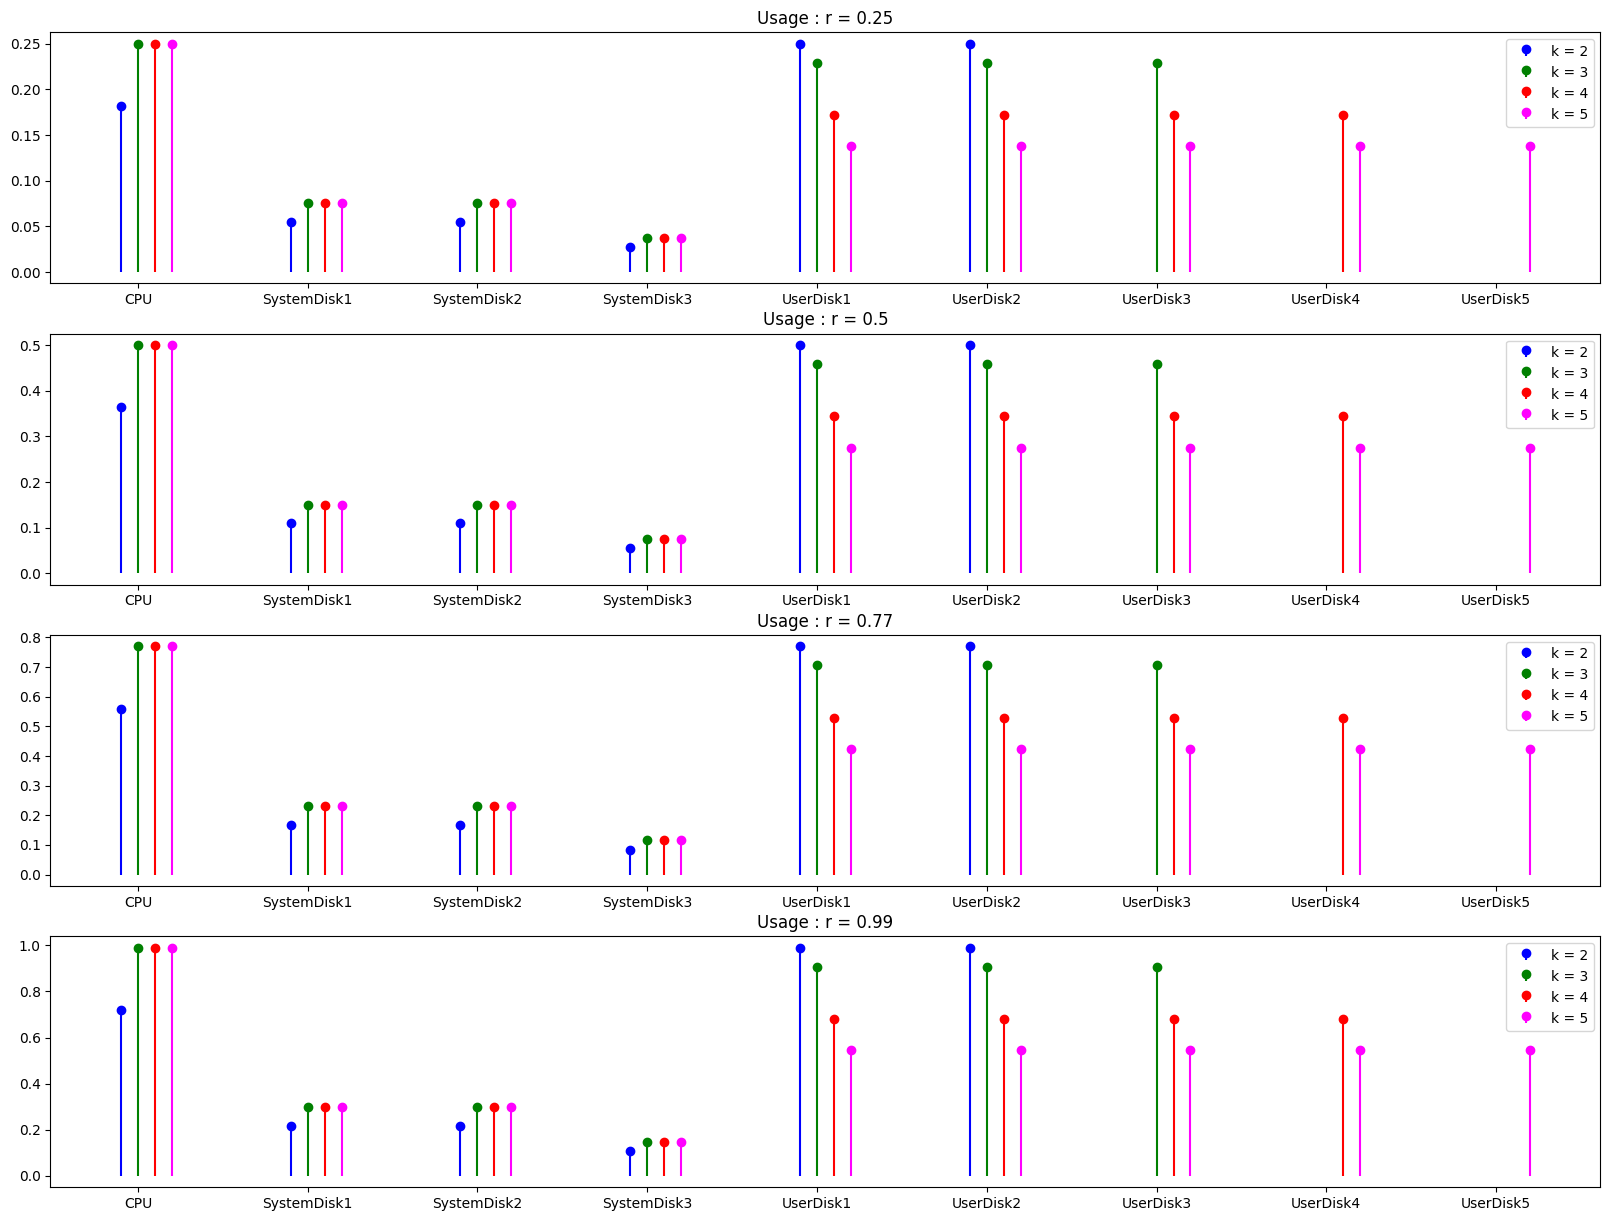

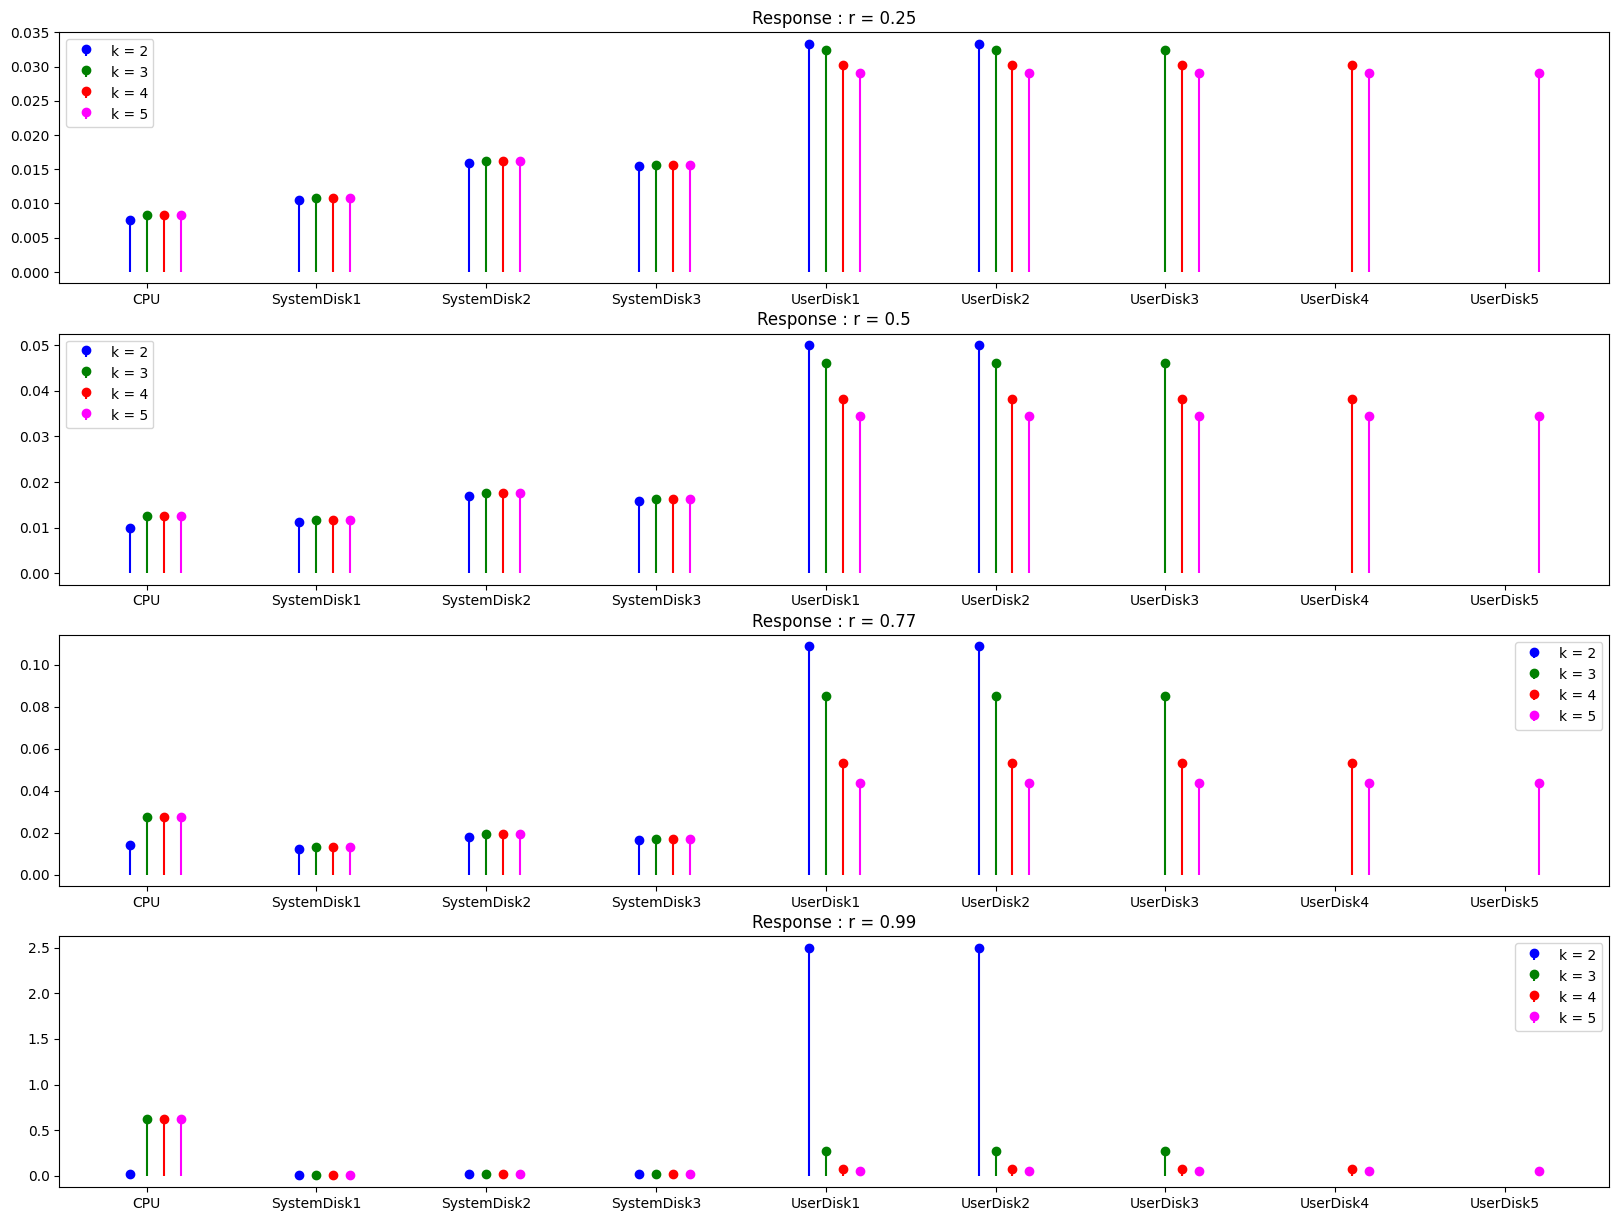

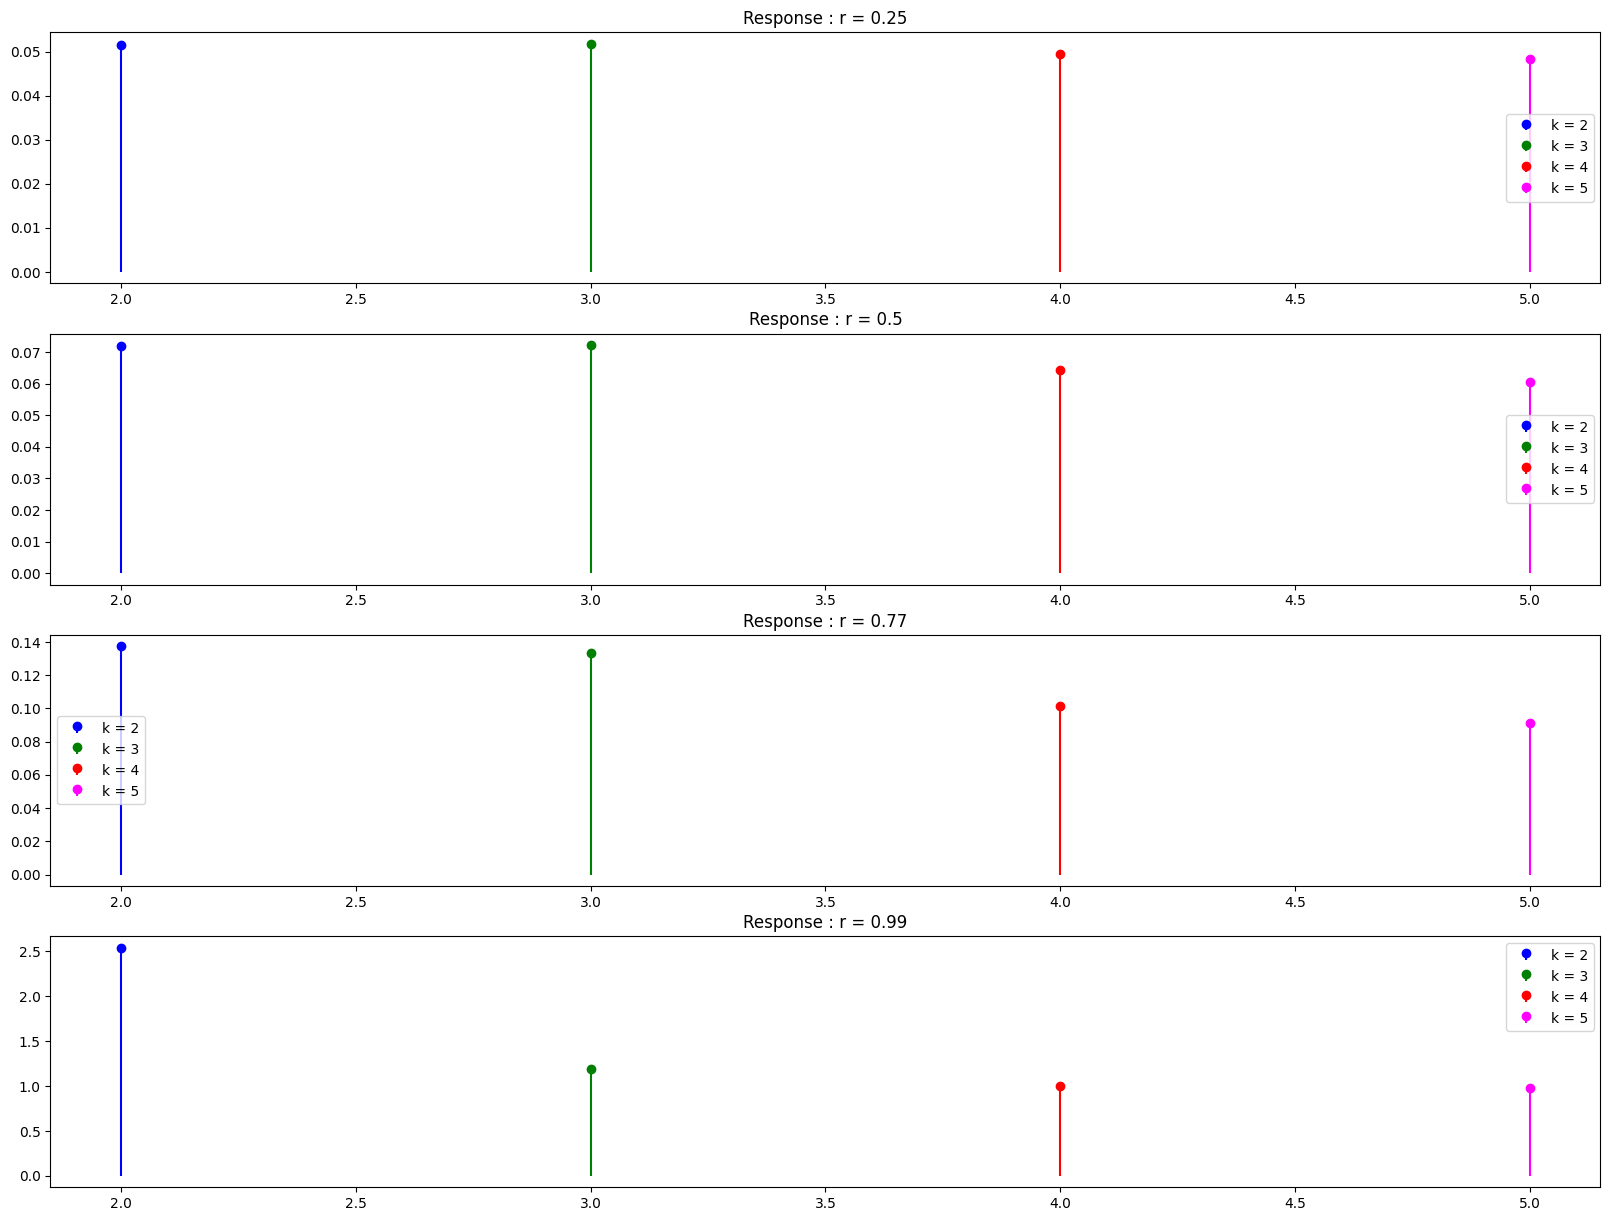

In [123]:
_, axis_U = plt.subplots(4,figsize=(20, 15))
_, axis_R = plt.subplots(4,figsize=(20, 15))
_, axis_Rsystem = plt.subplots(4,figsize=(20, 15))


colors = ['blue', 'green', 'red', 'magenta']

resources = ['CPU', 'SystemDisk1', 'SystemDisk2', 'SystemDisk3']

offset = 0

f = open('tables1', 'w+')

for ida, a in enumerate(a_max_arr):
  for idr, r in enumerate(r_arr):
    simulation = result_simulation['k' + str(ida + 2) + 'a' + str(round(a * r))]
    analyitical = result_analyitical['k' + str(ida + 2) + 'a' + str(round(a * r))]

    resources_prim = resources + ['UserDisk' + str(k+1) for k in range(ida+2)]
    x = np.arange(len(analyitical[1]))
    x = x + offset

    axis_U[idr].stem(x, analyitical[1], label='k = ' + str(ida+2), linefmt = colors[ida], basefmt=" ")
    axis_R[idr].stem(x, analyitical[3], label='k = ' + str(ida+2), linefmt = colors[ida], basefmt=" ")

    axis_U[idr].set_xticks([i + 0.1 for i in range(ida + 6)], resources_prim)
    axis_R[idr].set_xticks([i + 0.1 for i in range(ida + 6)], resources_prim)

    x = np.array(ida+2)
    axis_Rsystem[idr].stem(x, analyitical[4], label='k = ' + str(ida+2), linefmt = colors[ida], basefmt=" ")

    f.write('Diff table : K = ' + str(ida+2) + ' r = ' + str(r) + '\n')
    data = [
        ['Lambdas'] + np.absolute(analyitical[0] - simulation[0]).tolist(),
        ['Usages'] + np.absolute(analyitical[1] - simulation[1]).tolist(),
        ['J'] + np.absolute(analyitical[2] - simulation[2]).tolist(),
        ['Response'] + np.absolute(analyitical[3] - simulation[3]).tolist(),
    ]
    f.write('System Response = ' + str(abs(analyitical[4] - simulation[4])) + '\n')
    f.write(tabulate(data, resources_prim, tablefmt="grid") + '\n')

  offset += 0.1

f.close()

for idr, r in enumerate(r_arr):
  # for idk, k in enumerate(K):

  axis_U[idr].set_title("Usage : r = " + str(r))
  axis_U[idr].legend()

  axis_R[idr].set_title("Response : r = " + str(r))
  axis_R[idr].legend()

  axis_Rsystem[idr].set_title("Response : r = " + str(r))
  axis_Rsystem[idr].legend()

Sa grafika se vidi da kada je $K > 2$ iskorišćenje procesora je najveće te je procesor usko grlo sistema, ali kada imamo minimalno korisničkih diskova iskorišćenje diskova se povećava zato što je potrebno da svaki disk odradadi više posla. Pošto su korisnički diskovi najsporiji njihovo iskorišćenje će biti najveće.

Još jedna logična konstantacija je ta da povećanjem broja korisničkih diskova imamo i smanjenje u vremenu odziva sistema.

Kako se može videti iz rezultata simulacije i relativnih odstupanja, najveca odstupanja su kod J faktora, dok su za ostale faktore odstupanja relativno mala.

Što se tiče relativnih odstupanja u simulaciji sa jednim ciklusom i sumulacii sa 100 cikulsa, logično možemo primetiti veća odstupanja kod simulacije sa jednim ciklusom. Razlog ovoga su verovatnoće prelaza stanja. Kod duže simulacije imamo više prelaza te će verovatnoće biti sličnije onim iz analitičkih rezultata.